## Introduction and references

I was first made aware of this issue in http://haldanessieve.org/2014/03/21/author-post-genetic-influences-on-translation-in-yeast/, so we need to cite the post or the article.

For other informative references, see http://en.wikipedia.org/wiki/Total_least_squares and http://en.wikipedia.org/wiki/Errors-in-variables_models.  The problem we are trying to avoid here is attenuation bias or regression dilution (see http://en.wikipedia.org/wiki/Regression_dilution).

## Mass spec data and fitting

In [2]:
import numpy, pandas, scipy.stats, seaborn, pylab
%matplotlib inline

In [7]:
ms2_both_species = pandas.read_csv("Data_for_interference_ratios_plots/ALE_interference_set2_Y+H_MS2_BH.csv", index_col=1)
ms3_both_species = pandas.read_csv("Data_for_interference_ratios_plots/ALE_interference_set2_Y+H_MS3_BH.csv", index_col=1)
ms2_yeast = pandas.read_csv("Data_for_interference_ratios_plots/ALE_interference_set2_Y_only_MS2_BH.csv", index_col=1)
ms3_yeast = pandas.read_csv("Data_for_interference_ratios_plots/ALE_interference_set2_Y_only_MS3_BH.csv", index_col=1)

In [8]:
ms2_both_species.head()

,Unnamed: 0,126 Vert Med,127n Vert Med,127c Vert Med,128n Vert Med,128c Vert Med,129n Vert Med,batch_p_value,null_batch_p_value,1 vs 2,i_value,BH_value,Significant?,PepPerProt
ProteinID,,,,,,,,,,,,,,
YML009C,2819,312293.6903,307372.8028,305317.1813,853742.5699,835432.8687,842676.5201,4.170000e-08,0.512384,7.750000e-08,1,0.000172,True,1
YLR262C-A,2678,330290.1674,324090.2799,335944.6204,828722.5448,825534.7961,825114.2173,1.010000e-07,0.535342,1.670000e-08,2,0.000209,True,3
YCL026C-B,369,333521.3955,339539.8643,336577.0073,813773.4845,838498.8366,812688.3767,1.620000e-07,0.530168,5.930000e-07,3,0.000222,True,4
YJR060W,2163,853279.8707,836501.0098,842738.7702,395246.2931,406929.1902,400412.0544,2.130000e-07,0.490065,1.940000e-07,4,0.000219,True,5
Q0045,0,234746.4291,235839.0890,243317.0553,890467.3684,934305.2072,887251.1147,3.080000e-07,0.546969,1.720000e-06,5,0.000254,True,3


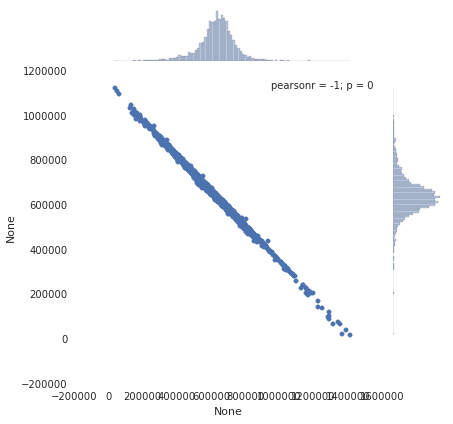

In [15]:
cols1 = ["126 Vert Med", "127n Vert Med", "127c Vert Med"]
cols2 = ["128n Vert Med", "128c Vert Med", "129n Vert Med"]
# ms2_yeast[cols1].mean(axis=1).shape
seaborn.jointplot(ms2_yeast[cols1].mean(axis=1), ms2_yeast[cols2].mean(axis=1))
pylab.show()
# what should I take the ratio of?

## Simulated results for testing

In [10]:
N = 1000
# true = scipy.stats.uniform.rvs(-5, 10, size=N)
true = scipy.stats.norm.rvs(0, 2, size=N)
x = true + scipy.stats.norm.rvs(0, 0.75, size=N)
y = true + scipy.stats.norm.rvs(0, 0.75, size=N)

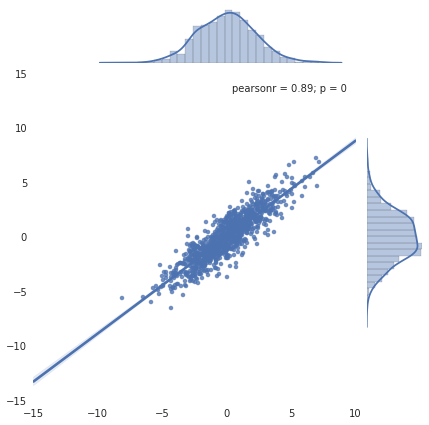

In [11]:
seaborn.jointplot(x, y, kind="reg")
pylab.show()

In [12]:
print scipy.stats.linregress(x, y)
print scipy.stats.linregress(y, x)

(0.88451032869013191, 0.035816096917443647, 0.88665831573313258, 0.0, 0.014602351708604615)
(0.88881151905025391, -0.02942931188806102, 0.88665831573313258, 0.0, 0.014673359917742402)


In [13]:
import scipy.odr
# quick version using the low-level function
print scipy.odr.odr(lambda b, x : b[0]*x + b[1], [1.0, 0.0], y, x, full_output=False)
print scipy.odr.odr(lambda b, x : b[0]*x + b[1], [1.0, 0.0], x, y, full_output=False)

(array([ 0.9972656 ,  0.03454838]), array([ 0.01547476,  0.03315362]), array([[  4.34550800e-04,  -4.88618577e-06],
       [ -4.88618577e-06,   1.99459479e-03]]))
(array([ 1.00273667, -0.0346428 ]), array([ 0.01555966,  0.03325166]), array([[  4.39331819e-04,  -2.01048737e-05],
       [ -2.01048737e-05,   2.00640849e-03]]))


In [14]:
# expanded version
model = scipy.odr.Model(lambda b, x : b[0]*x + b[1])
data = scipy.odr.Data(x, y)
odr = scipy.odr.ODR(data, model, beta0=[1.0, 0.0])
odr.set_job(fit_type=0) # 2 is vanilla least squares, which will match linregress (above)
fit = odr.run()
fit.pprint()
print "\n"
data = scipy.odr.Data(y, x)
odr = scipy.odr.ODR(data, model, beta0=[1.0, 0.0])
odr.set_job(fit_type=0) # 2 is vanilla least squares, which will match linregress (above)
fit = odr.run()
fit.pprint()

Beta: [ 0.9972656   0.03454838]
Beta Std Error: [ 0.01547476  0.03315362]
Beta Covariance: [[  4.34550800e-04  -4.88618577e-06]
 [ -4.88618577e-06   1.99459479e-03]]
Residual Variance: 0.55107074721
Inverse Condition #: 0.0487352444525
Reason(s) for Halting:
  Sum of squares convergence


Beta: [ 1.00273667 -0.0346428 ]
Beta Std Error: [ 0.01555966  0.03325166]
Beta Covariance: [[  4.39331819e-04  -2.01048737e-05]
 [ -2.01048737e-05   2.00640849e-03]]
Residual Variance: 0.551070747211
Inverse Condition #: 0.0488136972841
Reason(s) for Halting:
  Sum of squares convergence


Notice that the simple least squares estimates are downwardly-biased ($0.88$ here).  The total least squares estimates are much more accurate ($1.00$).
